In [7]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class model():
	'''
	Initializes the model
	Args:
		dim_in - dimensionality of input, integer
		hidden1 - number of nodes in 1st layer of nnet
		hidden2 - number of nodes in 2nd layer of nnet
		hidden3 - number of nodes in 3rd layer of nnet
		train_mode - boolean specifying whether model is to be trained  

	'''

	def __init__(self, dim_in=1, hidden1=10, hidden2=35, hidden3=20, train_mode = True):	
		self._dim_input = dim_in
		n_hidden1 = hidden1
		n_hidden2 = hidden2
		n_hidden3 = hidden3 #basis dimension
		self._basis_dim = n_hidden3
		dim_output = 1
		self._train_mode = train_mode

		if(train_mode == True):
			self._x_in = tf.placeholder(tf.float32, shape = [None,self._dim_input],name="plzwork1")
			self._x_inn = self._x_in

		else:
			self._x_in = tf.placeholder(tf.float32, shape = [1,self._dim_input],name="plzwork2")
			init_val  = np.random.normal(size = (1,self._dim_input))
			self._x_inn = tf.Variable(init_val,name = "wrtin",dtype= tf.float32)
			self._var_op = tf.assign(ref = self._x_inn, value=self._x_in, validate_shape = False)



		
		self._w1 = tf.Variable(tf.truncated_normal([self._dim_input,n_hidden1]))
		self._b1 = tf.Variable(tf.zeros([n_hidden1]))
		l1 = tf.nn.sigmoid(tf.matmul(self._x_inn,self._w1) + self._b1)
		
		self._w2 = tf.Variable(tf.truncated_normal([n_hidden1,n_hidden2]))
		self._b2 = tf.Variable(tf.zeros([n_hidden2]))
		l2 = tf.nn.sigmoid(tf.matmul(l1,self._w2) + self._b2)
		
		self._w3 = tf.Variable(tf.truncated_normal([n_hidden2,n_hidden3]))
		self._b3 = tf.Variable(tf.zeros([n_hidden3]))
		self._l3 = tf.nn.sigmoid(tf.matmul(l2,self._w3) + self._b3) #this output is the basis function
		
		self._w4 = tf.Variable(tf.truncated_normal([n_hidden3,dim_output]))
		self._b4 = tf.Variable(tf.zeros([dim_output]))
		self._y_pred = tf.matmul(self._l3,self._w4)  + self._b4
		
		#Saver object for saving nnet parameters
		self._save_params = tf.train.Saver({"w1":self._w1, "b1": self._b1,"w2":self._w2, "b2": self._b2,"w3":self._w3, "b3": self._b3, "w4":self._w4, "b4": self._b4})
	  
		
	def get_params(self):
		if(self._train_mode):
			return self._x_in, self._y_pred
		else:
			return self._x_in, self._x_inn, self._y_pred, self._l3, self._var_op, self._basis_dim
	def save_model(self,sess):
		save_path = self._save_params.save(sess,'model.ckpt')
		return save_path	
	def load_model(self, sess, path):
		self._save_params.restore(sess, path)


In [9]:
def train(xin, out, x_train,y_train, n_epochs, sess):
	
	Y_train = tf.placeholder(tf.float32, shape=[None,1], name="yyy")
	MSEloss = tf.reduce_mean(tf.square(Y_train-out))
	train = tf.train.AdamOptimizer().minimize(MSEloss)
	init_op = tf.initialize_all_variables()
	sess.run(init_op)     

	for i in range(n_epochs):  
		sess.run(train, feed_dict = {xin:x_train,Y_train: y_train})


In [18]:
class Bayesian():

	#dim(map_params) = (1,x_features)
	#dim(A) = (numtrain, x_features), dim(xtest) = (x_features, 1), dim(ytrain) = (numtrain,1)
	#dim(Av) = (x_features, x_features), dim(lambda_pos)=(1)
	
	
	'''
	Instantiates the class and computes 
	
		Args:
			basis - reference to the basis function, a tensorflow Tensor with shape = (basis dimensions, 1)
			xplaceholder - tensorflow placeholder, to provide input data
			xinn - input data in the form of a tf.Variable. Acquisiton function is optimized wrt this variable
			xtrain - numpy array of known function inputs, shape = (num_samples, num_dimensions)
			ytrain - numpy array of known corresponding function outputs to xtrain, shape = (num_samples,1)
			a - prior on weight variance(hyperparameter), a float
			b - prior on (hyperparameter), a float
			
	'''
	
	def __init__(self, basis, xplaceholder, xinn, xtrain, ytrain,basis_dim, a,b, sess, var_op):

		self._xinn = xinn
		self._a = a
		self._b = b
		self._sess = sess
		self._basis = basis
		self._xplaceholder = xplaceholder
		self._var_op = var_op

		iden = np.identity(basis_dim) 
		iden =  tf.cast(iden, tf.float64)
	
		self._A = np.zeros((len(xtrain), basis_dim))
		for i in range(len(xtrain)):
			self._sess.run(self._var_op, feed_dict = {self._xplaceholder: [xtrain[i]]}) 
			self._A[i,:] = sess.run(basis, feed_dict = {self._xplaceholder:[xtrain[i]]})

		self._A = tf.cast(self._A, tf.float64)
	
		self._Av = tf.matrix_inverse(self._a*tf.matmul(tf.transpose(self._A),self._A) + (self._b)*(self._b)*iden)
		self._A = tf.cast(self._A, tf.float64)
		self._Av = tf.cast(self._Av, tf.float64)

		self._inte = tf.matmul(self._Av, tf.transpose(self._A))

		self._map_params = tf.matmul(self._inte,ytrain)   #(30x1)(6x1)

		self._basis = tf.cast(self._basis, tf.float64)
		self._s1 = tf.matmul(self._basis, self._Av)
		self._phiK = tf.matmul(self._Av, tf.transpose(self._basis)) 
		self._sig =  (1/self._a) + tf.matmul(self._s1, tf.transpose(self._basis))
		self._mu_pos = self._a*tf.matmul(self._basis, self._map_params)     #self._a*   
		self._sample_min = np.min(ytrain) 

	'''
	Builds the posterior distribution function.
	note: function can be changed to return the posterior function at point xtest
	
	'''    

	def posterior(self):        
		self._xtest = self._basis
		self._xtest = tf.cast(self._xtest, tf.float64)
		s1 = tf.matmul(self._xtest, self._Av)
		self._phiK = tf.matmul(self._Av, tf.transpose(self._xtest)) 
		self._sig =  (1/self._a) + tf.matmul(s1, tf.transpose(self._xtest))
		self._mu_pos = self._b*tf.matmul(self._xtest, self._map_params)
		
		
	
	'''
	Optimizes the acquisiton function, maximizing the Expected Improvement criterion
	Args:
		trialx - 1x1 numpy array, specifying point to start optimization
	Returns:
		1x1 numpy array, specifying optimal point that maximizes expected improvemet
	
	'''
	
	def optimize_acquisition(self,trialx):
		#self._xtest=trialx
		self._gamma = ([self._sample_min] -  self._mu_pos[0])/self._sig[0]
		self._gamma = tf.cast(self._gamma[0], tf.float64)

		dist = tf.contrib.distributions.Normal(mu = tf.cast([0.0],tf.float64), sigma=tf.cast([1.0],tf.float64))
		ei = -1.0*(self._sig[0]*(self._gamma*dist.cdf(self._gamma)) + (dist.pdf(self._gamma)))
		ei = tf.cast(ei,tf.float64)
		self._objective_acq = tf.convert_to_tensor(ei) #+ #+2.0 #TODO: add expectation
		opt = tf.train.AdamOptimizer()
		#opt = tf.train.GradientDescentOptimizer(learning_rate=0.9)
		train_op = opt.minimize(self._objective_acq,var_list = [self._xinn])
		init_op = tf.initialize_all_variables()
		self._sess.run(init_op)
		self._sess.run(self._var_op, feed_dict = {self._xplaceholder: trialx})
		self._sess.run(train_op)
		return self._sess.run(self._xinn)
        #self._sess.run(np.random)
		#return self._sess.run(ei)#,feed_dict = {self._xplaceholder: trialx})        
	
	'''
		set the sample minimum based on the known data points
	'''
	def set_sample_min(self,minn):
		self._sample_min = minn
	def predict(self,trialx):
		self._sess.run(self._var_op, feed_dict = {self._xplaceholder:trialx})
		return self._sess.run((self._mu_pos[0],self._sig[0]))
	def get_ei(self, trialx):
		self._sess.run(self._var_op, feed_dict = {self._xplaceholder:trialx})
		return -1.0*self._sess.run(self._objective_acq)
        


In [19]:
def objective(x):
	y =np.random.rand()/10.0 + np.sin(x)# + np.cos(3*x)
	return y 

#train data
x_train = np.array([-6.0,-0.5, 1.5, 1.75, 2.0,3.0,8.0, 9.0])
#x_train = [-5.0, -1.0, 4.0, 10.0]
#np.random.shuffle(x_train)
y_train = objective(x_train)
x_train = np.reshape(x_train, (-1,1))
y_train = np.reshape(y_train, (-1,1))

#test data
xtest = np.linspace(-12.0,12.0,100)
ytest = objective(xtest)
xtest = np.reshape(xtest,(-1,1))
ytest = np.reshape(ytest,(-1,1))

y_preds = np.zeros(len(xtest))

sigs = np.zeros(len(xtest))
eis = np.zeros(len(xtest))


In [20]:
with tf.Session() as sess1:
    m1 = model()
    xplace_t,out_t = m1.get_params()
    train(xplace_t,out_t,x_train,y_train,10000, sess1)
    y_hat = sess1.run(out_t, feed_dict = {xplace_t:xtest})
    params_path = m1.save_model(sess1)
    


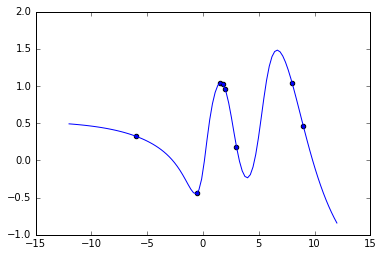

In [21]:
plt.scatter(x_train,y_train)
plt.plot(xtest, y_hat)

In [22]:
y_train

array([[ 0.32410819],
       [-0.43473285],
       [ 1.04218768],
       [ 1.02867864],
       [ 0.95399012],
       [ 0.1858127 ],
       [ 1.03405094],
       [ 0.45681118]])

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4


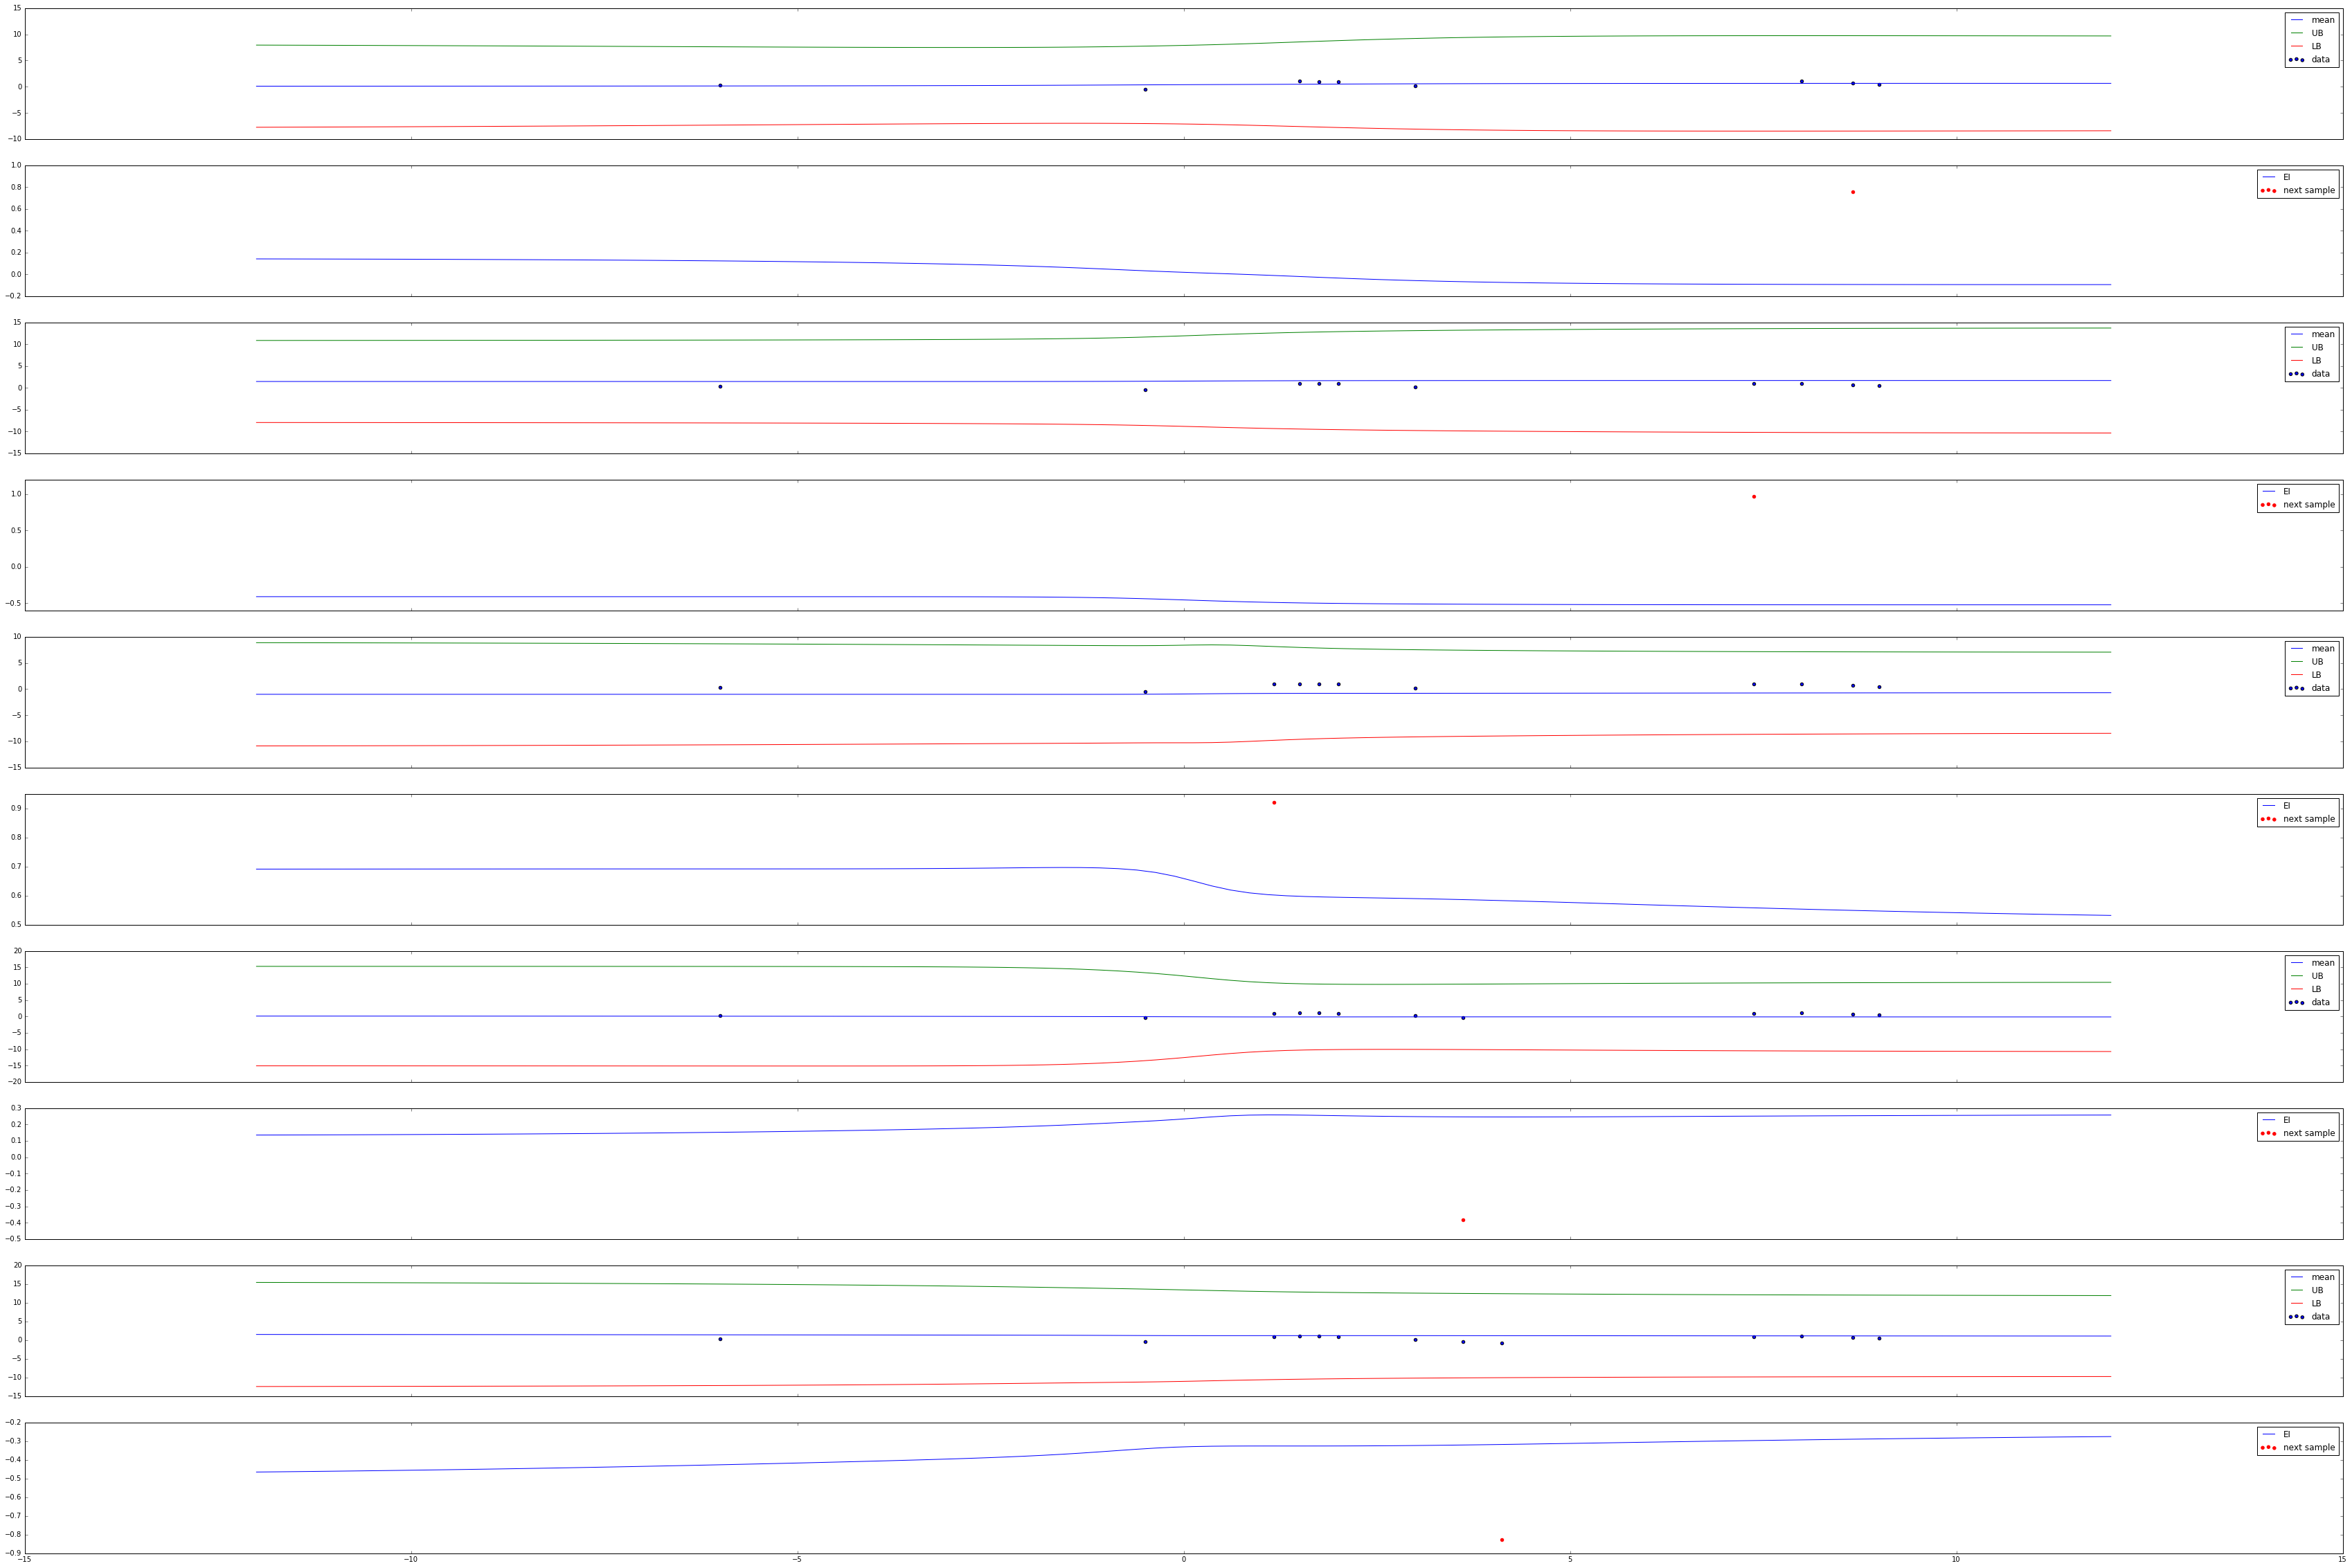

In [23]:
#xtrain is the known x-samples of the data, ytrain is the correpsonding values of the function
num_evals = 5
bestsofarx = np.zeros(num_evals)
bestsofary = np.zeros(num_evals)

y_preds = np.zeros((num_evals,len(xtest)))

sigs = np.zeros((num_evals,len(xtest)))
eis = np.zeros((num_evals,len(xtest)))


f, axarr = plt.subplots(int(2*num_evals), figsize = (60,40), sharex=True)
total_iter=0

while(total_iter<int(num_evals)):
    
    #train the basis function
    x_train = np.reshape(x_train,(-1,1))
    y_train = np.reshape(y_train,(-1,1))

    with tf.Session() as sess1:
        m1 = model()
        xplace_t,out_t = m1.get_params()
        train(xplace_t,out_t,x_train,y_train,10000, sess1)
        params_path = m1.save_model(sess1)
        

    with tf.Session() as sess2:

        m2 = model(train_mode=False)
        m2.load_model(sess2, params_path)
        x_start_p, x_start, y_hat, basis, var_op, basis_dim = m2.get_params()
        bayes = Bayesian(basis, x_start_p, x_start, x_train, y_train,basis_dim, 3.1,0.6, sess2, var_op)
        next_xsample = bayes.optimize_acquisition(10*np.random.rand(1,1)-0.5)
        next_ysample = objective(next_xsample)
        
        bestsofarx[total_iter] = next_xsample
        bestsofary[total_iter] = next_ysample
        x_train = np.append(x_train, next_xsample)
        y_train = np.append(y_train, next_ysample)
        
        for i in range(len(xtest)):
           y_preds[total_iter,i], sigs[total_iter,i] = bayes.predict([xtest[i]])
           eis[total_iter,i] = bayes.get_ei([xtest[i]])
    print("iteration: " + str(total_iter))
    
    axarr[2*total_iter].plot(xtest, y_preds[total_iter,:], label = 'mean')
    axarr[2*total_iter].plot(xtest, y_preds[total_iter,:] + sigs[total_iter,:],label = 'UB')
    axarr[2*total_iter].plot(xtest, y_preds[total_iter,:] - sigs[total_iter,:],label = 'LB')
    axarr[2*total_iter].scatter(x_train, y_train, label = 'data')
    axarr[2*total_iter].legend()
    
    axarr[2*total_iter+1].plot(xtest, eis[total_iter,:], label = 'EI')
    axarr[2*total_iter+1].scatter(next_xsample, next_ysample, color='r', label = 'next sample')
    axarr[2*total_iter+1].legend()
    
    #axarr[total_iter]
    '''
    x_train = np.append(x_train, next_xsample)
    y_train = np.append(y_train, next_ysample)
    axarr[i].scatter(x_train, y_train)
    axarr[i].plot(xtest, ytest + sigs)
    axarr[i].plot(xtest, ytest - sigs)
    axarr[i].fill_between(xtest[:,0], eis[:,0])
    print(i)
    i = i+1
    '''
    total_iter+=1
        
        

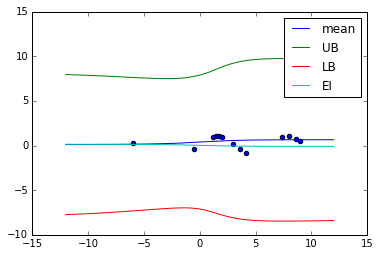

In [24]:
#plt.plot(xtest, eis[0,:])
eis
plt.plot(xtest,y_preds[0,:], label = 'mean')
plt.plot(xtest,y_preds[0,:] + sigs[0,:], label = 'UB')
plt.plot(xtest,y_preds[0,:] - sigs[0,:], label = 'LB')
plt.plot(xtest, eis[0,:], label = 'EI')
plt.scatter(x_train, y_train)
plt.legend()

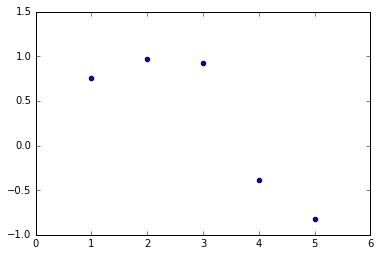

In [25]:
plt.scatter([1,2,3,4,5], bestsofary)


In [26]:
bestsofarx

array([ 8.66254807,  7.37918901,  1.16845596,  3.6151967 ,  4.11547709])

IndexError: too many indices for array

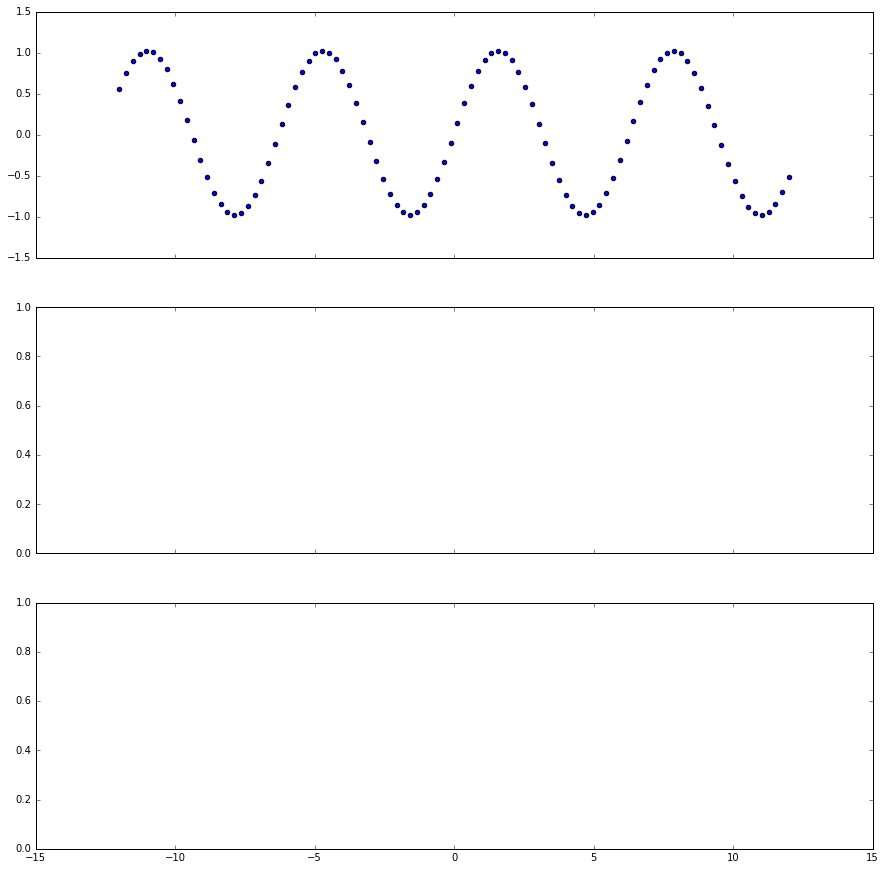

In [27]:
f, axarr = plt.subplots(3, sharex=True,figsize=(15,15))
axarr[0].scatter(xtest,ytest)
axarr[1].fill_between(x_train[:,0], y_train[:,0]+2, y_train[:,0]-2)

In [ ]:
axarr.